## Implementing local gauge invariance with atomic mixtures.

This Notebook is based on the following [paper](https://science.sciencemag.org/content/367/6482/1128), which was performed on the NaLi machine at SynQS. In this paper a new scalable analog quantum simulator of a U(1) gauge theory is demonstrated. 

By using interspecies spin-changing collisions between particles, a gauge-invariant interaction between matter and gauge-field is achieved. In this case an atomic mixture of sodium and lithium is used.

We will model the system with two qudits of slightly different length. The first qudit is the matter field and the second qudit the gauge field.


In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Rotating the matter field

we have to rotate the matter field to initialize the dynamics in the system first

In [106]:
from qiskit_cold_atom.providers import ColdAtomProvider
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

In [107]:
provider = ColdAtomProvider()
backend = provider.get_backend("collective_spin_simulator")

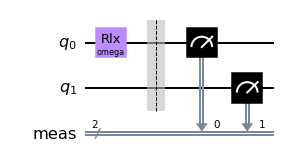

In [108]:
# sample at 50 angles between 0 and pi
spin =4
vals = 50
angles = np.linspace(0, np.pi, vals)

omega = Parameter("omega")

qc = QuantumCircuit(2)
qc.rlx(omega, [0])
qc.measure_all()

qc.draw('mpl')

and send the full circuit to the backend

In [109]:
Nshots = 150;
rabi_list = [qc.bind_parameters([angle]) for angle in angles]

job_rabi = backend.run(rabi_list, shots = Nshots, spin = spin, seed=5462)
result_rabi = job_rabi.result()

In [110]:
na_outcomes = np.zeros((Nshots,vals))
li_outcomes = np.zeros((Nshots,vals))

for ii in range(vals):
    res_array = result_rabi.get_memory(ii)
    for jj in range(Nshots):
        li_outcomes[jj,ii], na_outcomes[jj,ii]  = np.array(res_array[jj].split(' '), dtype=int)

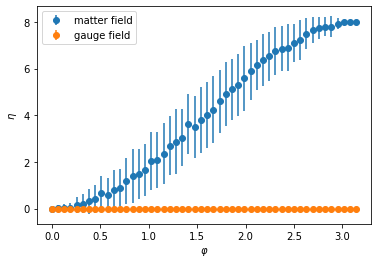

In [111]:
f, ax = plt.subplots()
ax.errorbar(angles, np.mean(na_outcomes, axis=0), yerr=np.std(na_outcomes, axis=0), fmt='o', label='matter field')
ax.errorbar(angles, np.mean(li_outcomes, axis=0), yerr=np.std(li_outcomes, axis=0), fmt='o', label='gauge field')

ax.set_ylabel(r'$\eta$')
ax.set_xlabel(r'$\varphi$')
ax.legend()

# Dynamics 

The preparation of the matter field is not the only thing, we also have to let the system evolve under the appropiate Hamiltonian.

In [112]:
from qiskit_cold_atom.providers import ColdAtomProvider

provider = ColdAtomProvider()

In [113]:
provider = ColdAtomProvider()
backend = provider.get_backend("collective_spin_simulator")

In [114]:
Delta = -2*np.pi*500;
chiT = 2.*np.pi*0.01*300e3;
lamT = 2.*np.pi*2e-4*300e3;#lamT = 2.*np.pi*2e-5*300e3;

In [115]:
NNa = 5;

# initial rotation of the matter field
alpha = np.pi/2;
chi = chiT/NNa;
lam = lamT/NNa;

In [116]:
import numpy as np

#time = Parameter("time")
time = 1e-3;

alpha = np.pi/2;

qc = QuantumCircuit(2)
qc.rlx(alpha, [0])

qc.barrier()
qc.rlz2(chi*time, [0])
qc.rlz(Delta*time, [1])
qc.rlxly(lam*time, [0, 1])
qc.measure_all()

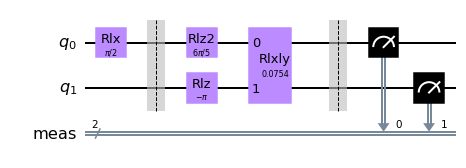

In [117]:
qc.draw('mpl')

In [118]:
Ntimes = 20;
tlin = np.linspace(0,30,Ntimes)*1e-3;
memory_list = []
for ii in range(Ntimes):
    time = tlin[ii];
    alpha = np.pi/2;
    
    qc = QuantumCircuit(2)
    qc.rlx(alpha, [0])

    qc.barrier()
    qc.rlz2(chi*time, [0])
    qc.rlz(Delta*time, [1])
    qc.rlxly(lam*time, [0, 1])
    qc.measure_all()
    job = backend.run(qc, shots = Nshots, spin = NNa/2, seed=5462)
    result = job.result()
    memory_list.append(result.get_memory())

In [119]:
na_outcomes = np.zeros((Nshots,Ntimes))
li_outcomes = np.zeros((Nshots,Ntimes))

for ii in range(Ntimes):
    res_array = memory_list[ii]
    for jj in range(Nshots):
        li_outcomes[jj,ii], na_outcomes[jj,ii]  = np.array(res_array[jj].split(' '), dtype=int)

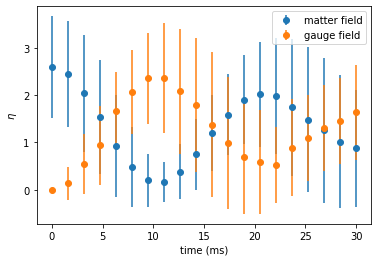

In [120]:
f, ax = plt.subplots()
ax.errorbar(tlin*1e3, np.mean(na_outcomes, axis=0), yerr=np.std(na_outcomes, axis=0), fmt='o', label='matter field')
ax.errorbar(tlin*1e3, np.mean(li_outcomes, axis=0), yerr=np.std(li_outcomes, axis=0), fmt='o', label='gauge field')

ax.set_ylabel(r'$\eta$')
ax.set_xlabel(r'time (ms)')
ax.legend()

# Now on the remote device

In [121]:
from qiskit_cold_atom.providers import ColdAtomProvider
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

In [122]:
provider = ColdAtomProvider.load_account()

spin_device_backend = provider.get_backend("synqs_multi_qudit_simulator")
print(spin_device_backend.configuration().supported_instructions)

/Users/fredjendrzejewski/Documents/GitHub/qiskit-cold-atom/qiskit_cold_atom/providers/cold_atom_provider.py:252: UserWarning: No stored credentials found
  warnings.warn("No stored credentials found")


QiskitBackendNotFoundError: 'No backend matches criteria.'

In [ ]:
# sample at 50 angles between 0 and pi
NNa = 10; # number of atoms in sodium
NLi = 1; # number of atoms in lithium

vals = 15
angles = np.linspace(0, np.pi, vals)

omega = Parameter("omega")

qc = QuantumCircuit(2)
qc.load_spins(NNa, 0)
qc.load_spins(NLi, 1)
qc.rlx(omega, [0])
qc.measure_all()

qc.draw('mpl')

and send the full circuit to the backend

In [ ]:
Nshots = 150;
rabi_list = [qc.bind_parameters([angle]) for angle in angles]
job_rabi = spin_device_backend.run(rabi_list, shots = Nshots)


In [ ]:
job_retrieved = spin_device_backend.retrieve_job(job_id=job_rabi.job_id())

print("job status: ", job_retrieved.status())

In [ ]:
result_rabi = job_retrieved.result()

In [ ]:
na_outcomes = np.zeros((Nshots,vals))
li_outcomes = np.zeros((Nshots,vals))

for ii in range(vals):
    res_array = result_rabi.get_memory(ii)
    for jj in range(Nshots):
        na_outcomes[jj,ii], li_outcomes[jj,ii]  = np.array(res_array[jj].split(' '), dtype=int)

In [ ]:
f, ax = plt.subplots()
ax.errorbar(angles, np.mean(na_outcomes, axis=0), yerr=np.std(na_outcomes, axis=0), color='C1', label='gauge field')
ax.errorbar(angles, np.mean(li_outcomes, axis=0), yerr=np.std(li_outcomes, axis=0), color='C0', label='matter field')

ax.set_ylabel(r'$\eta$')
ax.set_xlabel(r'$\varphi$')
ax.legend()

# Dynamics 

The preparation of the matter field is not the only thing, we also have to let the system evolve under the appropiate Hamiltonian.

In [ ]:
Delta = -2*np.pi*500;
chiT = 2.*np.pi*0.01*300e3;
lamT = 2.*np.pi*2e-4*300e3;#lamT = 2.*np.pi*2e-5*300e3;

In [ ]:
NNa = 10; # number of atoms in sodium
NLi = 1; # number of atoms in lithium

# initial rotation of the matter field
alpha = np.pi/2;
chi = chiT/NNa;
lam = lamT/NNa;

In [ ]:
import numpy as np

time = Parameter("time")
#time = 1e-3;

alpha = np.pi/2;

qc = QuantumCircuit(2)
qc.load_spins(NNa, 0)
qc.load_spins(NLi, 1)

qc.rlx(alpha, [0])
qc.rlz2(chi*time, [0])
qc.rlz(Delta*time, [1])
qc.rlxly(lam*time, [0, 1])
qc.measure_all()

In [ ]:
qc.draw('mpl')

In [ ]:
Ntimes = 10;
tlin = np.linspace(0,30,Ntimes)*1e-3;
job_list = []
for ii in range(Ntimes):
    time = tlin[ii];
    alpha = np.pi/2;
    
    qc = QuantumCircuit(2)
    qc.load_spins(NNa, 0)
    qc.load_spins(NLi, 1)
    qc.rlx(alpha, [0])

    qc.barrier()
    qc.rlz2(chi*time%2*np.pi, [0])
    qc.rlz(Delta*time%2*np.pi, [1])
    qc.rlxly(lam*time, [0, 1])
    qc.measure_all()
    job_list.append(qc)

job_dynamics = spin_device_backend.run(job_list, shots = Nshots)

In [ ]:
job_dynamics.job_id()

In [ ]:
job_retrieved = spin_device_backend.retrieve_job(job_id=job_dynamics.job_id())

print("job status: ", job_retrieved.status())

In [ ]:
result_dynamics = job_retrieved.result()

In [ ]:
na_outcomes = np.zeros((Nshots,Ntimes))
li_outcomes = np.zeros((Nshots,Ntimes))

for ii in range(Ntimes):
    res_array = result_dynamics.get_memory(ii)
    for jj in range(Nshots):
        na_outcomes[jj,ii], li_outcomes[jj,ii]  = np.array(res_array[jj].split(' '), dtype=int)

now format it for the same presentation like in the paper etc.

In [ ]:
f, (ax1,ax2) = plt.subplots(2,1, sharex = True)
ax1.errorbar(tlin*1e3, np.mean(li_outcomes, axis=0), yerr=np.std(li_outcomes, axis=0), color='C0',fmt='o', label='matter field')
ax1.set_ylabel(r'$\eta$')

ax2.errorbar(tlin*1e3, np.mean(na_outcomes, axis=0)-NNa/2, yerr=np.std(na_outcomes, axis=0), color='C1', fmt='o', label='gauge field')
ax2.set_ylabel(r'$L_z$')
ax2.set_xlabel(r'time (ms)')